# STAT3612 Group Project

The theme of this semester is interpretable machine learning (IML) with applications to a real datacase study.

For an IML model, both **prediction accuracy and model explainability are equally important**. 
You will need to take both objectives into account when building models in this project.

The data includes about 10,400 anonymized Home Equity Line of Credit (HELOC) loans,together with 23 attributes. 

Note that in the second Excel file the monotonicity constraints are included in the data dictionary, which are based on the prior knowledge about the feature-target effect. 

**Build your IML models based only on the training data**.  
There is no restriction in the choice of feature engineering techniques or machine learning algorithms. 

The final model evaluations will be based on three aspects:
1.  Prediction accuracy as tested on the remaining 20% dataset
2.  Global interpretability about the model effects
3.  Local interpretability about individual predictions (Good/Bad cases from testing data).

## Importing Libraries

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

from tabulate import tabulate # printing output as tables

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Reading datasets

In [159]:
pd.set_option('display.max_colwidth', -1) # show complete variable names
heloc = pd.read_csv('HelocData.csv')
dataDict = pd.read_excel('HelocDataDict2.xlsx')
dataDict['Description'] = dataDict['Description'].apply(
    lambda x: x.split('.')[0] if '.' in x else x)[1:] # Only extract the first sentence

In [160]:
#Calculate median of every column based on non-special values 
median=np.zeros(23)

for i in range(0,23):
    median[i]= np.median(heloc[features[i]][(heloc[features[i]] > -7)])   
   

First, remove rows with -9, as these rows are missing data in all columns excpet for RiskFlag, and only add noise
Next impute -8 entries with the median of each column they're in
Finally, -7 represents a condition not being met, and so should be categorised seperately to other feature values, and so we represent it with negative one

In [162]:
for i in range(0,23):
    heloc=heloc[heloc[features[i]] > -9] 
    heloc[features[i]].where(heloc[features[i]]>-8, median[i], inplace=True)
    heloc[features[i]].where(heloc[features[i]]>-7, other=-1, inplace=True)
heloc.head()    

,RiskFlag,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
0,Bad,75,169,2,59,21,0,0,100,-1,...,36,-1,4,4,43,112,4,6,0,83
1,Bad,66,502,4,145,34,0,0,97,36,...,27,4,3,3,80,53,17,3,12,83
2,Good,69,338,2,62,22,0,0,96,12,...,35,0,4,4,25,100,3,2,1,45
3,Good,75,422,1,91,55,0,0,100,-1,...,33,0,4,4,2,11,12,2,1,57
4,Bad,63,242,2,68,25,0,0,100,-1,...,19,-1,3,3,73,74,12,1,5,87


In [163]:
label_encoder = LabelEncoder()
heloc['RiskFlag'] = label_encoder.fit_transform(heloc['RiskFlag']) # encode 0/1 to RiskFlag

In [164]:
GID = 20190006 # group Id
np.random.seed(GID) # set GID as random seed

# create binary 0/1 'good/bad' variable in dataframe
y = heloc['RiskFlag']
X = heloc.drop('RiskFlag', axis=1)

In [165]:
# Compare Algorithms

models = [('LR', LogisticRegression(solver='newton-cg',C=1e6)), 
          ('CART', DecisionTreeClassifier()), 
          ('SVM', SVC(gamma='scale', kernel='rbf')), 
          ('XGB', XGBClassifier())
         ]

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy') 
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
   

LR: 0.729439 (0.008569)
CART: 0.631783 (0.014988)
SVM: 0.728830 (0.005331)
XGB: 0.733292 (0.005743)


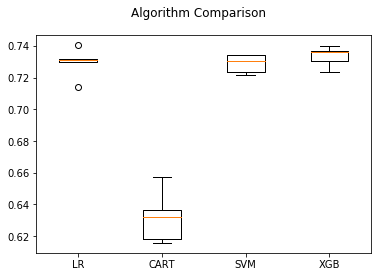

In [166]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From the analysis above, logistic regression performs as well as the two black box models, support vector machines and gradient boosted trees.

We also notice that SVM takes a long time to train compared to Logistic Regression- this is a problem in a production setting.

Logisitic regression gives us a natural way of interpreting the model output- 'probabilities' of repaying a loan.  

---

## EDA and feature engineering

Logistic Regression requires the features to be uncorrelated, so we must remove or combine features so as to not have heavily correlated ones inlcuded in the model

In [167]:
corr = heloc.corr()
corr.style.background_gradient(cmap='coolwarm')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,RiskFlag,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
RiskFlag,1,0.46,0.21,0.054,0.25,0.14,-0.17,-0.14,0.26,-0.036,0.24,0.22,0.1,-0.078,-0.14,0.17,-0.14,-0.14,-0.35,-0.049,-0.13,-0.052,-0.24,-0.28
x1,0.46,1,0.25,0.15,0.33,0.00017,-0.41,-0.34,0.51,-0.1,0.57,0.5,-0.039,-0.19,-0.17,0.15,-0.21,-0.21,-0.62,-0.032,-0.34,-0.18,-0.45,-0.45
x2,0.21,0.25,1,0.1,0.69,0.24,-0.012,-0.028,0.039,0.029,-0.0082,-0.0033,0.27,-0.11,-0.19,0.087,-0.11,-0.1,-0.17,-0.071,0.12,-0.03,-0.0043,-0.22
x3,0.054,0.15,0.1,1,0.4,-0.25,0.027,0.026,-0.13,-0.044,-7.8e-05,0.011,-0.22,-0.46,-0.025,0.049,-0.17,-0.18,-0.061,-0.093,-0.17,-0.16,-0.079,-0.0065
x4,0.25,0.33,0.69,0.4,1,0.12,0.038,0.013,-0.044,0.031,-0.016,-0.035,0.09,-0.35,-0.2,0.09,-0.18,-0.18,-0.19,-0.1,0.012,-0.12,-0.049,-0.21
x5,0.14,0.00017,0.24,-0.25,0.12,1,-0.12,-0.12,0.26,0.029,-0.006,0.039,0.85,0.31,-0.13,0.032,0.096,0.097,-0.069,-0.042,0.48,0.35,0.22,-0.23
x6,-0.17,-0.41,-0.012,0.027,0.038,-0.12,1,0.89,-0.53,0.19,-0.42,-0.59,-0.025,-0.057,0.11,-0.062,0.038,0.038,0.09,-0.0082,-0.05,0.029,-0.021,0.11
x7,-0.14,-0.34,-0.028,0.026,0.013,-0.12,0.89,1,-0.38,0.16,-0.37,-0.5,-0.04,-0.05,0.11,-0.057,0.041,0.041,0.062,0.0003,-0.063,0.013,-0.033,0.097
x8,0.26,0.51,0.039,-0.13,-0.044,0.26,-0.53,-0.38,1,-0.21,0.51,0.64,0.17,0.15,-0.13,0.07,0.0066,0.0081,-0.16,0.025,0.079,0.047,-0.0027,-0.18
x9,-0.036,-0.1,0.029,-0.044,0.031,0.029,0.19,0.16,-0.21,1,-0.072,-0.49,0.04,0.033,0.049,-0.012,0.013,0.013,0.055,0.022,0.016,0.025,0.011,0.037


We can see the most correlated features are x6 and x7, x5 and x12, and x16 and x17.
Those that dont get combined or removed through feature engineering, will be removed at the end

In [182]:
# new features 
heloc_tmp=heloc.copy()

# First we use x2 and x3 to get time spam of oldest to most recent trade open
heloc_tmp['x24']=(heloc['x2']-heloc['x3'])

#Using x8 and x4 we can create a new feature incorporating length of time in file with non-deliquent trades
heloc_tmp['x25']=heloc['x8']*heloc_tmp['x4']

#x2 and x4 are also highly correlated so we combine them
heloc_tmp['x26']= heloc['x2']/heloc['x4']

heloc_tmp['x27']=(.7*heloc['x16'])+(.3*heloc['x17'])-heloc['x15']

heloc_tmp['x28']=(heloc['x19']*heloc['x21'])/(heloc['x14']+1)

heloc_tmp['x29']=heloc['x21']/(heloc_tmp['x12']*heloc_tmp['x14']+0.1)#number of installment trades


#Using x5 and x4 we can create a new feature incorporating length of time in file with satisfactory trades
heloc_tmp['x30']=heloc['x5']*heloc['x4']

In [183]:
features = heloc_tmp.columns.tolist()[1:] # updated list of features

heloc_train, heloc_test = train_test_split(heloc_tmp, test_size=0.2, random_state=GID) # 80/20 train/test split

In [184]:
# Binning

import scorecardpy as sc

heloc_train_tmp=heloc_train.copy()
heloc_test_tmp=heloc_test.copy()

for i in range(len(features)):
    bins = sc.woebin(heloc_train_tmp, y='RiskFlag',x=features[i], method='tree')
    breaks = np.insert(bins[features[i]]['breaks'].values.astype(np.float), 0, -np.inf)

    heloc_train_tmp[features[i]] = pd.cut(heloc_train_tmp[features[i]], bins=breaks, right=True)
    heloc_test_tmp[features[i]] = pd.cut(heloc_test_tmp[features[i]], bins=breaks, right=True)

[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...
[INFO] creating woe binning ...


In [185]:
# Discretize into categorical variables

label_encoder = LabelEncoder()

for i in range(len(features)):
    heloc_train_tmp[features[i]] = label_encoder.fit_transform(heloc_train_tmp[features[i]])
    heloc_test_tmp[features[i]] = label_encoder.fit_transform(heloc_test_tmp[features[i]])

---

# Feature Selection

We have added new feaures, and have not yet removed correlated feautures, so we would like to compare the value of the features for predicting RiskFlag Good/Bad
We will have use the different methods to select a maximum of 25 features, and drop any features that are selected by less than three of the mehods
Then we will remove feautures that are correlated, keeping the ones that are higher ranked 

In [186]:
features_tmp = heloc_train_tmp.columns.tolist()[1:]
num_feats=25
X = heloc_train_tmp.drop('RiskFlag', axis=1)
y = heloc_train_tmp['RiskFlag']

In [187]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

25 selected features


In [188]:
from sklearn.feature_selection import RFE
rfe_selector = RFE(estimator=LogisticRegression(solver='newton-cg'), 
                   n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 30 features.
25 selected features


In [189]:
from sklearn.feature_selection import SelectFromModel

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

25 selected features


In [190]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

13 selected features


In [191]:
from sklearn.feature_selection import SelectFromModel

xgbc=XGBClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_xgb_selector = SelectFromModel(xgbc, max_features=num_feats)
embeded_xgb_selector.fit(X, y)

embeded_xgb_support = embeded_xgb_selector.get_support()
embeded_xgb_feature = X.loc[:,embeded_xgb_support].columns.tolist()
print(str(len(embeded_xgb_feature)), 'selected features')

11 selected features


In [192]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(n_estimators=500)

embeded_etc_selector=SelectFromModel(etc, max_features=num_feats)
embeded_etc_selector.fit(X, y)

embeded_etc_support=embeded_etc_selector.get_support()
embeded_etc_feature= X.loc[:,embeded_etc_support].columns.tolist()
print(str(len(embeded_etc_feature)), 'selected features')

13 selected features


In [193]:
feature_selection_df = pd.DataFrame(
    {'Feature':features_tmp, 'Chi-2':chi_support, 
     'RFE':rfe_support, 'Logistics':embeded_lr_support,
     'Random Forest':embeded_rf_support, 'XGB':embeded_xgb_support,
     'ETC' :embeded_etc_support})

# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display features by importance
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [194]:
feature_selection_df

,Feature,Chi-2,RFE,Logistics,Random Forest,XGB,ETC,Total
1,x8,True,True,True,True,True,True,6
2,x30,True,True,True,True,True,True,6
3,x25,True,True,True,True,True,True,6
4,x23,True,True,True,True,True,True,6
5,x18,True,True,True,True,True,True,6
6,x1,True,True,True,True,True,True,6
7,x27,True,True,True,True,False,True,5
8,x24,True,True,True,True,False,True,5
9,x4,True,True,True,False,True,False,4
10,x3,False,True,True,True,False,True,4


Based on the ranked table of features, and on the correlation matrix, we remove variables

In [196]:
###
drop=feature_selection_df[feature_selection_df['Total'] <3]['Feature'].tolist()
print(drop)

['x28', 'x11', 'x6', 'x13', 'x12']


From the correlated features, and based on the above table we also want to drop x17

In [197]:
corr_drop=['x17']
drop= drop+ corr_drop

heloc_train_tmp_tmp = heloc_train_tmp.drop(drop,axis=1) # update heloc with removed features
heloc_train_tmp_tmp.head()

,RiskFlag,x1,x2,x3,x4,x5,x7,x8,x9,x10,...,x20,x21,x22,x23,x24,x25,x26,x27,x29,x30
1679,0,0,2,1,3,3,0,2,3,1,...,3,0,1,3,2,2,1,4,0,3
7639,1,3,2,4,3,2,0,3,0,2,...,0,0,0,0,2,2,1,3,2,2
45,1,0,1,0,1,3,0,3,0,1,...,2,3,1,4,1,0,1,3,2,2
3074,1,2,2,1,3,3,0,3,0,2,...,2,1,0,3,2,3,0,0,3,3
2794,0,0,3,1,3,3,0,1,1,0,...,3,1,1,4,3,3,1,1,0,3


In [198]:
heloc_train=heloc_train_tmp.drop(drop,axis=1)
heloc_test=heloc_test_tmp.drop(drop,axis=1)

---

## Model Building

In [199]:
# split dataset into train and testing for model evaluation

X_train = heloc_train.drop('RiskFlag', axis=1)
y_train = heloc_train['RiskFlag']
X_test = heloc_test.drop('RiskFlag', axis=1)
y_test = heloc_test['RiskFlag']

In [200]:
## Hyperparameter tuning

lr = LogisticRegression()
param_grid_1 = dict(penalty = ['l2'], C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], solver=[ 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], multi_class=['ovr'], class_weight=[None,'balanced'])
param_grid_2 = dict(penalty = ['l1', 'l2'], C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], solver=['liblinear', 'saga'], multi_class=['ovr'],class_weight=[None,'balanced'])
param_grid_3 = dict(penalty = ['l1', 'l2', 'elasticnet' ], C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], solver=['saga'], multi_class=['ovr'],class_weight=[None,'balanced'])

grid = GridSearchCV(estimator=lr,
                    param_grid=param_grid_1,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1,
                    cv=5)

grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

grid = GridSearchCV(estimator=lr,
                    param_grid=param_grid_2,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1,
                    cv=5)

grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

grid = GridSearchCV(estimator=lr,
                    param_grid=param_grid_3,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1,
                    cv=5)

grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   26.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.7389739064322127
Best Params:  {'C': 0.1, 'class_weight': None, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   19.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.7389739064322127
Best Params:  {'C': 0.1, 'class_weight': None, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   12.0s finished


Best Score:  0.7387199387905835
Best Params:  {'C': 0.1, 'class_weight': None, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'saga'}


In [201]:
lr = LogisticRegression(penalty='l2',C=0.1,solver='liblinear',multi_class='ovr')
lr=lr.fit(X_train, y_train)

y_pred=lr.predict(X_test)

acc_test = accuracy_score(y_test,y_pred)
print(acc_test)

0.7247845919918905


## Model Evaluation

In [203]:
# Accuracy / Error rate
def accuracy(y_true, X, model):
    y_pred = model.predict(X)
    return accuracy_score(y_true, y_pred)

print('Training accuracy score: ', accuracy(y_train, X_train, lr))
print('Test accuracy score: ', accuracy(y_test, X_test, lr))

Training accuracy score:  0.7422667342799188
Test accuracy score:  0.7247845919918905


In [204]:
y_train_pred = lr.predict_proba(X_train)[:,1]
y_test_pred = lr.predict_proba(X_test)[:,1]

acc_train = roc_auc_score(y_train,y_train_pred)
acc_test = roc_auc_score(y_test,y_test_pred)
    
print('The ROC score on training set:',acc_train)
print('The ROC score on testing set:',acc_test)

The ROC score on training set: 0.8089733585870057
The ROC score on testing set: 0.7953872763934365


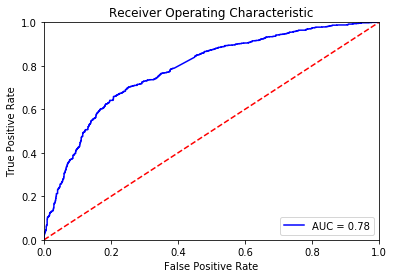

In [158]:
fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Conclusion